In [1]:
from operator import itemgetter

import tqdm
import bs4
import feedparser
import seaborn as sns

In [2]:
medium_publications = [
    'the-artificial-impostor',
    'pytorch',
    'dair.ai',
    'towards-artificial-intelligence',
    'swlh',
    '@ODSC',
    'doctrine',
    'paperswithcode'
]


medium_url_template = 'https://medium.com/feed/{}'
medium_url = medium_url_template.format(medium_publications[0])
medium_urls = [medium_url_template.format(publication) for publication in medium_publications]

In [3]:
subreddits = [
    'MachineLearning',
    'deeplearning',
    'datascience',
    'cognitivelinguistics',
    'TopOfArxivSanity',
    'kaggle'
]

reddit_url_template = 'https://www.reddit.com/r/{}/.rss'
reddit_url = reddit_url_template.format(subreddits[0])
reddit_urls = [reddit_url_template.format(subreddit) for subreddit in subreddits]

In [4]:
feed = feedparser.parse(reddit_url)

In [5]:
len(feed['entries'])

26

In [6]:
articles = feed['entries']

In [7]:
def get_article_text(article):
    article_html_content = article['content'][0]['value']
    article_text = bs4.BeautifulSoup(article_html_content).text
    return article_text


def get_feed_article_texts(feed):
    return [get_article_text(article) for article in feed['entries'] if 'content' in article.keys()]

In [8]:
feeds = [
    feedparser.parse(feed_url)
    for feed_url in tqdm.tqdm(medium_urls + reddit_urls)
]

100%|██████████| 14/14 [00:07<00:00,  1.84it/s]


In [9]:
article_texts = [
    text 
    for feed in feeds
    for text in get_feed_article_texts(feed)
]

In [10]:
article_texts

['Generate questions and answers from both real and synthetic contextsPhoto Credit(This post was originally published on my personal\xa0blog.)Preamble“Training Question Answering Models From Synthetic Data” is an NLP paper from Nvidia that I found very interesting. Question and answer(QA) data is expansive to obtain. If we can use the data we have to generate more data, that will be a huge time saver and create a lot of new possibilities. This paper shows some promising results in this direction.Some caveats:We need big models to be able to get decent results. (The paper reported question generation models with the number of parameters from 117M to 8.3B. See the ablation study in the following sections.)Generated QA data is still not at the same level as the real data. (At least 3x+ more synthetic data is needed to reach the same level of accuracy.)There are a lot of contents in this paper, and it can be a bit overwhelming. I wrote down parts of the paper that I think is most relevant 

In [11]:
from ktrain import text 
zsl = text.ZeroShotClassifier()

In [12]:
article_texts[0]

'Generate questions and answers from both real and synthetic contextsPhoto Credit(This post was originally published on my personal\xa0blog.)Preamble“Training Question Answering Models From Synthetic Data” is an NLP paper from Nvidia that I found very interesting. Question and answer(QA) data is expansive to obtain. If we can use the data we have to generate more data, that will be a huge time saver and create a lot of new possibilities. This paper shows some promising results in this direction.Some caveats:We need big models to be able to get decent results. (The paper reported question generation models with the number of parameters from 117M to 8.3B. See the ablation study in the following sections.)Generated QA data is still not at the same level as the real data. (At least 3x+ more synthetic data is needed to reach the same level of accuracy.)There are a lot of contents in this paper, and it can be a bit overwhelming. I wrote down parts of the paper that I think is most relevant i

In [13]:
len(article_texts[0].split())

1456

In [14]:
example_article = article_texts[10]

In [15]:
topic_strings = [
    'deep learning',
    'natural language processing',
    'computer vision',
    'visualization',
    'industry',
    'implementation',
    'computer programming',
    'reddit question',
    'research',
    'startup'
]
results = zsl.predict(example_article, topic_strings=topic_strings, include_labels=True, max_length=256)
results = sorted(results, key=itemgetter(1), reverse=True)

In [16]:
example_article

'Author: Chris Padwick, Director of Computer Vision and Machine Learning at Blue River TechnologyHow did farming affect your day today? If you live in a city, you might feel disconnected from the farms and fields that produce your food. Agriculture is a core piece of our lives, but we often take it for\xa0granted.A 2017 prototype of See & Spray, Blue River Technology’s precision weed control\xa0machineFarmers today face a huge challenge\u200a—\u200afeeding a growing global population with less available land. The world’s population is expected to grow to nearly 10 billion by 2050, increasing the global food demand by 50%. As this demand for food grows, land, water, and other resources will come under even more pressure. The variability inherent in farming, like changing weather conditions, and threats like weeds and pests also have consequential effects on a farmer’s ability to produce food. The only way to produce more food while using less resources is through smart machines that can

In [17]:
categories = [c for c, __ in results]
scores = [score for __, score in results]

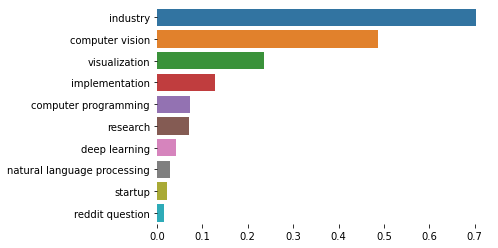

In [18]:
sns.barplot(scores, categories)
sns.despine(left=True, bottom=True)